In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)

In [ ]:
x = np.load('./smiley_X.npy')
y = np.load('./smiley_y.npy')

X = x.reshape((144, 81))
X.shape

(144, 81)

In [ ]:
def blank(height=9, width=9):
    return [[0. for x in range(width)] for y in range(height)]

def bound(x, l=0, h=10):
    if x < l:
        return l
    if x > h:
        return h
    return x

def draw_feature(canvas, feature, origin=(0,0)):
  (x0, y0) = origin
  for (x, y) in feature:
      canvas[x0 + x][y0 + y] = 1.

def draw_face(eyes, mouth, noise):
  canvas = blank()
  #draw eyes
  draw_feature(canvas, eyes)
  draw_feature(canvas, mouth)
  draw_feature(canvas, noise)
  return canvas


def print_face(face):
    for line in face:
        for x in line:
            print ('X' if x == 1.0 else '.', end='')
        print('')
    print('')


def make_data(noise=False):
  x_train = np.ndarray(shape=(0,))
  y_train = np.ndarray(shape=(0,))

  eyes_variants = [
      [(2, 2), (2, 6)],
      [(2, 1), (2, 7)],
      [(2, 1), (2, 5)],
      [(2, 2), (2, 7)],
      [(2, 3), (2, 5)],
      
      [(1, 1), (1, 5)],
      [(1, 1), (1, 6)],
      [(1, 1), (1, 7)],
      
      [(1, 2), (1, 5)],
      [(1, 2), (1, 6)],
      [(1, 2), (1, 7)],
      
      [(1, 3), (1, 5)],
      [(1, 3), (1, 6)],
      [(1, 3), (1, 7)],
      
      [(1, 1), (1, 6), (1, 7)],
      [(1, 1), (1, 2), (1, 7)],
      [(2, 1), (2, 6), (2, 7)],
      [(2, 1), (2, 2), (2, 7)],
      
      [(1, 1), (1, 2), (1, 6), (1, 7)],
      [(1, 1), (1, 2), (2, 5), (2, 6)],
      [(2, 1), (2, 2), (1, 5), (1, 6)],
      [(2, 1), (2, 2), (2, 6), (2, 7)]
  ]


  noise_variants = [
#       # No noise
#       [],
      
#       # Noise in the eyes
#       [(0, 0)],
#       [(0, 8)],
#       [(2, 0)],
#       [(2, 1)],
#       [(2, 2)],
#       [(2, 4)],
#       [(2, 5)],
#       [(2, 7)],
#       [(2, 8)],
      
      # Noise around the mouth
      [(4, 1)],
      [(4, 2)],
      [(4, 3)],
      [(4, 4)],
      [(4, 6)],
      [(4, 7)],
      
      [(5, 1)],
      [(5, 2)],
      [(5, 4)],
      [(5, 6)],
      [(5, 7)],
      [(5, 8)],

      [(6, 1)],
      [(6, 3)],
      [(6, 6)],
      [(6, 8)],
      
      [(7, 1)],
      [(7, 2)],
      [(7, 5)],
      [(7, 7)]
  ]

    
  happy_mouths = [
      # Mouth 1
      [(4, 1), (5, 2), (6, 3), (6, 4), (6, 5), (5, 6), (4, 7)],
      [(4, 2), (5, 3), (6, 4), (6, 5), (6, 6), (5, 7), (4, 8)],
      [(4, 0), (5, 1), (6, 2), (6, 3), (6, 4), (5, 5), (4, 6)],
      
      [(5, 1), (6, 2), (7, 3), (7, 4), (7, 5), (6, 6), (5, 7)],
      [(5, 2), (6, 3), (7, 4), (7, 5), (7, 6), (6, 7), (5, 8)],
      [(5, 0), (6, 1), (7, 2), (7, 3), (7, 4), (6, 5), (5, 6)],
      
      [(6, 1), (7, 2), (8, 3), (8, 4), (8, 5), (7, 6), (6, 7)],
      [(6, 2), (7, 3), (8, 4), (8, 5), (8, 6), (7, 7), (6, 8)],
      [(6, 0), (7, 1), (8, 2), (8, 3), (8, 4), (7, 5), (6, 6)],

      
      # Mouth 2
      [(4, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (4, 7)],
      [(4, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (4, 8)],
      [(4, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (4, 6)],
      
      [(5, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (5, 7)],
      [(5, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (5, 8)],
      [(5, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (5, 6)],
      
      [(6, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (6, 7)],
      [(6, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (6, 8)],
      [(6, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (6, 6)],
      

      # Mouth 3
      [(5, 2), (6, 3), (6, 4), (6, 5), (5, 6)],
      [(5, 1), (6, 2), (6, 3), (6, 4), (5, 5)],
      [(5, 3), (6, 4), (6, 5), (6, 6), (5, 7)],
      
      [(6, 2), (7, 3), (7, 4), (7, 5), (6, 6)],
      [(6, 1), (7, 2), (7, 3), (7, 4), (6, 5)],
      [(6, 3), (7, 4), (7, 5), (7, 6), (6, 7)],
      
      [(7, 2), (8, 3), (8, 4), (8, 5), (7, 6)],
      [(7, 1), (8, 2), (8, 3), (8, 4), (7, 5)],
      [(7, 3), (8, 4), (8, 5), (8, 6), (7, 7)],
      
      
      # Added extra
      [(4, 2), (5, 3), (6, 4), (5, 5), (4, 6)],
      [(4, 1), (5, 2), (6, 3), (5, 4), (4, 5)],
      [(4, 3), (5, 4), (6, 5), (5, 6), (4, 7)],
      [(5, 2), (6, 3), (7, 4), (6, 5), (5, 6)],
      
      [(4, 1), (5, 2), (6, 3), (6, 4), (7, 5), (6, 6), (5, 5), (6, 5), (5, 7)],
      [(4, 1), (5, 2), (6, 2), (7, 3), (7, 4), (7, 5), (6, 6), (5, 6), (4, 7)],
      
      [(4, 2), (5, 2), (6, 3), (6, 4), (7, 5), (5, 6), (4, 6)],
      [(4, 1), (5, 2), (6, 2), (7, 3), (6, 4), (6, 5), (6, 6), (5, 6)],
      [(4, 0), (5, 1), (6, 2), (7, 3), (7, 4), (7, 5), (6, 6), (5, 7), (4, 8)],
      
      
       # Slight happy face
      [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (5, 5)],
      [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (4, 5)],
      [(6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (5, 6)],
      [(5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (4, 6)],
      
      
      # Neutral
      [(5, 2), (5, 3), (5, 4), (5, 5), (5, 6)],
      [(6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
      
  ]


  sad_mouths = [
      # Mouth 1
      [(5, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 7)],
      [(5, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 8)],
      [(5, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 6)],
      
      [(6, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 7)],
      [(6, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 8)],
      [(6, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 6)],
      
      [(7, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 7)],
      [(7, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 8)],
      [(7, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 6)],

      
      # Mouth 2
      [(6, 1), (5, 2), (4, 3), (4, 4), (4, 5), (5, 6), (6, 7)],
      [(6, 2), (5, 3), (4, 4), (4, 5), (4, 6), (5, 7), (6, 8)],
      [(6, 0), (5, 1), (4, 2), (4, 3), (4, 4), (5, 5), (6, 6)],
      
      [(7, 1), (6, 2), (5, 3), (5, 4), (5, 5), (6, 6), (7, 7)],
      [(7, 2), (6, 3), (5, 4), (5, 5), (5, 6), (6, 7), (7, 8)],
      [(7, 0), (6, 1), (5, 2), (5, 3), (5, 4), (6, 5), (7, 6)],
      
      [(8, 1), (7, 2), (6, 3), (6, 4), (6, 5), (7, 6), (8, 7)],
      [(8, 2), (7, 3), (6, 4), (6, 5), (6, 6), (7, 7), (8, 8)],
      [(8, 0), (7, 1), (6, 2), (6, 3), (6, 4), (7, 5), (8, 6)],
      
      
      # Mouth 3  
      [(6, 2), (5, 3), (5, 4), (5, 5), (6, 6)],
      [(6, 3), (5, 4), (5, 5), (5, 6), (6, 7)],
      [(6, 1), (5, 2), (5, 3), (5, 4), (6, 5)],
      
      [(7, 2), (6, 3), (6, 4), (6, 5), (7, 6)],
      [(7, 3), (6, 4), (6, 5), (6, 6), (7, 7)],
      [(7, 1), (6, 2), (6, 3), (6, 4), (7, 5)],
      
      [(8, 2), (7, 3), (7, 4), (7, 5), (8, 6)],
      [(8, 3), (7, 4), (7, 5), (7, 6), (8, 7)],
      [(8, 1), (7, 2), (7, 3), (7, 4), (8, 5)],
      
      
      # Added extra
      [(7, 2), (6, 2), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 6), (7, 6)],
      [(7, 1), (6, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 5), (7, 5)],
      [(7, 3), (6, 3), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 7), (7, 7)],
      [(6, 2), (5, 2), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 6), (6, 6)],
      
      [(7, 1), (6, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 6), (7, 7)],
      [(6, 1), (5, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 6), (6, 7)],
      
      [(5, 2), (5, 3), (6, 4), (6, 5), (7, 6)],
      [(6, 1), (5, 2), (5, 3), (5, 4), (6, 5), (7, 6)],
      [(7, 1), (6, 1), (6, 2), (5, 3), (5, 4), (6, 5), (6, 6), (7, 6)],
      
      
      # Slight sad face
      [(7, 1), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)],
      [(6, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)],
      [(7, 2), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)],
      [(6, 2), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)],
      
      
      # Neutral
      [(5, 2), (5, 3), (5, 4), (5, 5), (5, 6)],
      [(6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
      
      
  ]
  
  for noise in noise_variants:
    for mouth in happy_mouths:
      for eyes in eyes_variants:
        #   if noise:
        #     noise = noise_variants[randint(0, len(noise_variants - 1))]
        #   else: 
        #     noise = []
        face = draw_face(eyes, mouth, noise)
        face = np.array(face)
        face.shape = (1, 9, 9, 1)
        x_train = np.concatenate((x_train, face), axis=0) if x_train.size else face
        y_train = np.append(y_train, 0)
    for mouth in sad_mouths:
      for eyes in eyes_variants:
        #   if noise:
        #     noise = noise_variants[randint(0, len(noise_variants - 1))]
        #   else: 
        #     noise = []
        face = draw_face(eyes, mouth, noise)
        face = np.array(face)
        face.shape = (1, 9, 9, 1)
        x_train = np.concatenate((x_train, face), axis=0) if x_train.size else face
        y_train = np.append(y_train, 1)

  x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=0)

  return (x_train, y_train), (x_test, y_test)

In [ ]:
# Model / data parameters
num_classes = 2
input_shape = (9, 9, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = make_data()

# Scale images to the [0, 1] range
x_train_original = x_train.astype("float32")
x_test_original = x_test.astype("float32")
print("x_train shape:", x_train_original.shape)
print(x_train_original.shape[0], "train samples")
print(x_test_original.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train_original = keras.utils.to_categorical(y_train, num_classes)
y_test_original = keras.utils.to_categorical(y_test, num_classes)

class_name=["SAD","HAPPY"]

x_train shape: (27720, 9, 9, 1)
27720 train samples
9240 test samples


In [ ]:
np.save("smiley_X_train.npy", x_train_original)
np.save("smiley_Y_train.npy", y_train_original)

np.save("smiley_X_test.npy", x_test_original)
np.save("smiley_Y_test.npy", y_test_original)

In [ ]:
x_train_original.shape, x_test_original.shape, y_train_original.shape, y_test_original.shape

((27720, 9, 9, 1), (9240, 9, 9, 1), (27720, 2), (9240, 2))

In [ ]:
x_train_full = x_train_original
x_test_full = x_test_original
y_train_full = y_train_original[:, 0].astype(np.int)
y_test_full = y_test_original[:, 0].astype(np.int)

In [ ]:

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression

In [ ]:
X_train = x_train_full.reshape((27720, 81)) # (number of instances, image size e.g. 9x9=81)
X_test = x_test_full.reshape((9240, 81))
Y_train = y_train_full
Y_test = y_test_full

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((27720, 81), (27720,), (9240, 81), (9240,))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)

In [ ]:
x_train = x_train_full.reshape((27720, 9, 9)) # (number of instances, image size e.g. 9x9=81)
x_test = x_test_full.reshape((9240, 9, 9))
y_train = y_train_full
y_test = y_test_full

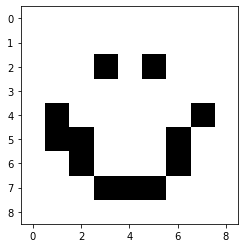

'HAPPY'

In [ ]:
plt.imshow(x_train[12000], cmap = "binary")
plt.show()
class_name[y_train_full[12000]]

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape= [9, 9]),
    keras.layers.Dense(30, activation="sigmoid"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(2, activation="softmax"),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 81)                0         
                                                                 
 dense (Dense)               (None, 30)                2460      
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 3,122
Trainable params: 3,122
Non-trainable params: 0
_________________________________________________________________


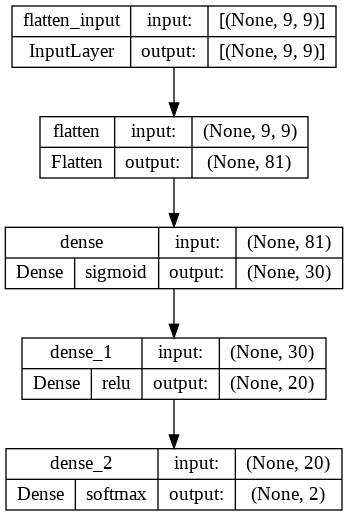

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [ ]:
weights, biases = model.layers[1].get_weights()

In [ ]:
weights.shape, biases.shape

((81, 30), (30,))

In [ ]:
model.compile(optimizer="SGD",
              loss="BinaryCrossentropy",
              metrics=["Accuracy", "Precision", "Recall", 
                       "TrueNegatives", "TruePositives", 
                       "FalseNegatives", "FalsePositives", "AUC"])


# Losses: "BinaryCrossentropy", "Hinge", "SquaredHinge", "MeanAbsoluteError"
# metrics: "BinaryAccuracy", "Hinge", "BinaryCrossentropy", "MeanAbsoluteError", "Accuracy", "Precision", 
#          "Recall", "TrueNegatives", "TruePositives", "FalseNegatives", "FalsePositives", "AUC"

In [ ]:
x_valid, x_train = x_train_original[:2700], x_train_original[2700:]
y_valid, y_train = y_train_original[:2700], y_train_original[2700:]

In [ ]:
x_valid.shape, x_train.shape

((2700, 9, 9, 1), (25020, 9, 9, 1))

In [ ]:
y_valid.shape, y_train.shape

((2700, 2), (25020, 2))

In [ ]:

result = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid))

Epoch 1/30
782/782 [==============================] - 37s 47ms/step - loss: 0.6948 - Accuracy: 0.4990 - precision: 0.4990 - recall: 0.4990 - true_negatives: 12486.0000 - true_positives: 12486.0000 - false_negatives: 12534.0000 - false_positives: 12534.0000 - auc: 0.5012 - val_loss: 0.6923 - val_Accuracy: 0.5270 - val_precision: 0.5270 - val_recall: 0.5270 - val_true_negatives: 1423.0000 - val_true_positives: 1423.0000 - val_false_negatives: 1277.0000 - val_false_positives: 1277.0000 - val_auc: 0.5424
Epoch 2/30
782/782 [==============================] - 39s 50ms/step - loss: 0.6921 - Accuracy: 0.5243 - precision: 0.5243 - recall: 0.5243 - true_negatives: 13119.0000 - true_positives: 13119.0000 - false_negatives: 11901.0000 - false_positives: 11901.0000 - auc: 0.5453 - val_loss: 0.6913 - val_Accuracy: 0.5644 - val_precision: 0.5644 - val_recall: 0.5644 - val_true_negatives: 1524.0000 - val_true_positives: 1524.0000 - val_false_negatives: 1176.0000 - val_false_positives: 1176.0000 - val_

In [ ]:

result.history.keys()

dict_keys(['loss', 'Accuracy', 'precision', 'recall', 'true_negatives', 'true_positives', 'false_negatives', 'false_positives', 'auc', 'val_loss', 'val_Accuracy', 'val_precision', 'val_recall', 'val_true_negatives', 'val_true_positives', 'val_false_negatives', 'val_false_positives', 'val_auc'])

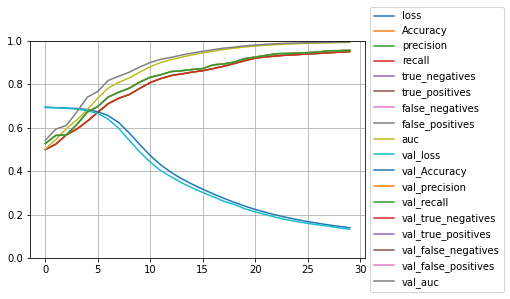

In [ ]:
pd.DataFrame(result.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)

In [ ]:
# 0 for sad & 1 for happy

# Use to laod data from file
x_train_full = np.load("./smiley_X_train.npy")
y_train_full = np.load("./smiley_Y_train.npy")
x_test_full = np.load("./smiley_X_test.npy")
y_test_full = np.load("./smiley_Y_test.npy")


y_train = y_train_full
y_test = y_test_full.astype(np.int)
x_test = x_test_full
x_valid, x_train = x_train_full[:2700], x_train_full[2700:]
y_valid, y_train = y_train_full[:2700].astype(np.int), y_train_full[2700:].astype(np.int)

class_name=["SAD","HAPPY"]

In [ ]:
x_train_full.shape, x_valid.shape, x_train.shape, x_test.shape

((27720, 9, 9, 1), (2700, 9, 9, 1), (25020, 9, 9, 1), (9240, 9, 9, 1))

In [ ]:
y_train_full.shape, y_valid.shape, y_train.shape, y_test.shape

((27720, 2), (2700, 2), (25020, 2), (9240, 2))

TypeError: ignored

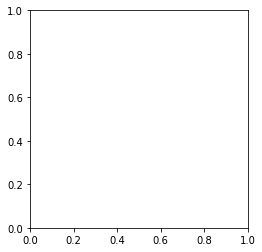

In [ ]:
plt.imshow(x_valid[10], cmap = "binary")
plt.show()
class_name[y_valid[10, 0]]

In [ ]:
def process_data(dataset):
    output = []
    for i in range(len(dataset)):
        current = dataset[i]
        if current[0] > current[1]:
            output.append(1)
        elif current[0] < current[1]:
            output.append(0)
        else:
            output.append(0)
    return output


def get_scores(model, history, x_test, y_test):
    y_test = y_test[:,0]
    pred = model.predict(x_test)
    pred = process_data(pred)
    # model.summary()  # Include for view of model

    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    cm = confusion_matrix(y_test, pred)

    print("Accuracy:", accuracy)
    print("F1 Score: ", f1)
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    plt.show() 
    
    # Inlcude to view graph over training
    # pd.DataFrame(history.history).plot()
    # plt.grid(True)
    # plt.gca().set_ylim(0, 1)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.show()

Epoch 1/5
782/782 [==============================] - 15s 19ms/step - loss: 0.2992 - Accuracy: 0.8590 - val_loss: 0.0735 - val_Accuracy: 0.9711
Epoch 2/5
782/782 [==============================] - 15s 19ms/step - loss: 0.0658 - Accuracy: 0.9744 - val_loss: 0.0675 - val_Accuracy: 0.9711
Epoch 3/5
782/782 [==============================] - 22s 28ms/step - loss: 0.0579 - Accuracy: 0.9733 - val_loss: 0.0510 - val_Accuracy: 0.9737
Epoch 4/5
782/782 [==============================] - 13s 17ms/step - loss: 0.0520 - Accuracy: 0.9734 - val_loss: 0.0507 - val_Accuracy: 0.9741
Epoch 5/5
289/289 [==============================] - 1s 4ms/step
Accuracy: 0.9729437229437229
F1 Score:  0.9727312390924956
Precision Score:  0.9647338814366075
Recall Score:  0.980862296524417


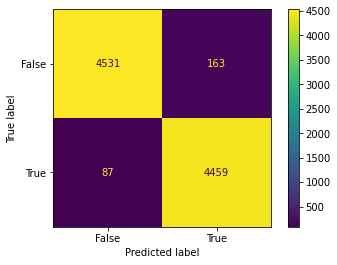

In [ ]:
m = keras.models.Sequential([
    keras.layers.Flatten(input_shape= [9, 9]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])


# Activations: "relu", "sigmoid", "tanh", "softmax", "swish"



m.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),
          loss="BinaryCrossentropy",
          metrics=["Accuracy"])


# Losses: "BinaryCrossentropy", "Hinge", "SquaredHinge", "MeanAbsoluteError"
# metrics: "BinaryAccuracy", "Hinge", "BinaryCrossentropy", "MeanAbsoluteError", "Accuracy", "Precision", 
#          "Recall", "TrueNegatives", "TruePositives", "FalseNegatives", "FalsePositives", "AUC"

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)



r = m.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

get_scores(m, r, x_test, y_test)


Epoch 1/5
782/782 [==============================] - 12s 15ms/step - loss: 0.6552 - Accuracy: 0.6470 - val_loss: 0.6086 - val_Accuracy: 0.7193
Epoch 2/5
782/782 [==============================] - 12s 15ms/step - loss: 0.5707 - Accuracy: 0.7490 - val_loss: 0.5163 - val_Accuracy: 0.7959
Epoch 3/5
782/782 [==============================] - 12s 16ms/step - loss: 0.4853 - Accuracy: 0.8002 - val_loss: 0.4419 - val_Accuracy: 0.8256
Epoch 4/5
782/782 [==============================] - 13s 16ms/step - loss: 0.4224 - Accuracy: 0.8275 - val_loss: 0.3908 - val_Accuracy: 0.8459
Epoch 5/5
289/289 [==============================] - 1s 3ms/step
Accuracy: 0.8560606060606061
F1 Score:  0.8559358752166377
Precision Score:  0.8431498079385403
Recall Score:  0.8691157061152661


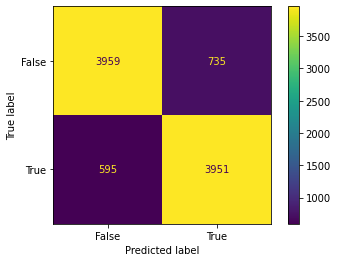

In [ ]:
m = keras.models.Sequential([
    keras.layers.Flatten(input_shape= [9, 9]),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])
m.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
          loss="BinaryCrossentropy",
          metrics=["Accuracy"])

# Activations: "relu", "sigmoid", "tanh", "softmax", "swish"
# Losses: "BinaryCrossentropy", "Hinge", "SquaredHinge", "MeanAbsoluteError"
# metrics: "BinaryAccuracy", "Hinge", "BinaryCrossentropy", "MeanAbsoluteError", "Accuracy", "Precision","Recall", "TrueNegatives", "TruePositives", "FalseNegatives", "FalsePositives", "AUC"
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)

r = m.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))
get_scores(m, r, x_test, y_test)

Epoch 1/5
782/782 [==============================] - 15s 18ms/step - loss: 0.6916 - Accuracy: 0.5324 - val_loss: 0.6804 - val_Accuracy: 0.6433
Epoch 2/5
782/782 [==============================] - 14s 19ms/step - loss: 0.6242 - Accuracy: 0.7185 - val_loss: 0.5418 - val_Accuracy: 0.7519
Epoch 3/5
782/782 [==============================] - 15s 19ms/step - loss: 0.4553 - Accuracy: 0.8008 - val_loss: 0.3538 - val_Accuracy: 0.8752
Epoch 4/5
782/782 [==============================] - 15s 19ms/step - loss: 0.2964 - Accuracy: 0.8894 - val_loss: 0.2414 - val_Accuracy: 0.9067
Epoch 5/5
289/289 [==============================] - 1s 4ms/step
Accuracy: 0.9244588744588744
F1 Score:  0.9241634072142547
Precision Score:  0.9130528123658223
Recall Score:  0.9355477342718874


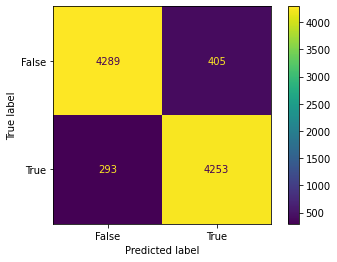

In [ ]:
m = keras.models.Sequential([
    keras.layers.Conv2D(10, (3,3), activation="relu", input_shape=(9, 9, 1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(input_shape= [9, 9]),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])
m.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
          loss="BinaryCrossentropy",
          metrics=["Accuracy"])

# Activations: "relu", "sigmoid", "tanh", "softmax", "swish"
# Losses: "BinaryCrossentropy", "Hinge", "SquaredHinge", "MeanAbsoluteError"
# metrics: "BinaryAccuracy", "Hinge", "BinaryCrossentropy", "MeanAbsoluteError", "Accuracy", "Precision","Recall", "TrueNegatives", "TruePositives", "FalseNegatives", "FalsePositives", "AUC"
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)

r = m.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))
get_scores(m, r, x_test, y_test)

Epoch 1/5
782/782 [==============================] - 15s 19ms/step - loss: 0.6927 - Accuracy: 0.5551 - val_loss: 0.6888 - val_Accuracy: 0.6441
Epoch 2/5
782/782 [==============================] - 15s 19ms/step - loss: 0.6817 - Accuracy: 0.7035 - val_loss: 0.6702 - val_Accuracy: 0.7415
Epoch 3/5
782/782 [==============================] - 15s 19ms/step - loss: 0.6417 - Accuracy: 0.7749 - val_loss: 0.5972 - val_Accuracy: 0.8219
Epoch 4/5
782/782 [==============================] - 17s 22ms/step - loss: 0.5188 - Accuracy: 0.8281 - val_loss: 0.4229 - val_Accuracy: 0.8596
Epoch 5/5
289/289 [==============================] - 1s 4ms/step
Accuracy: 0.9007575757575758
F1 Score:  0.9008755810182683
Precision Score:  0.885653560042508
Recall Score:  0.9166300043994721


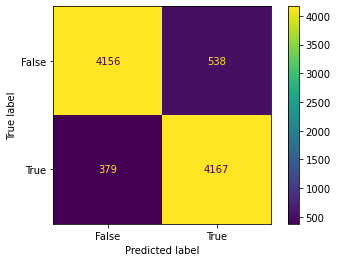

In [ ]:
m = keras.models.Sequential([
    keras.layers.Conv2D(10, (3,3), activation="relu", input_shape=(9, 9, 1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(input_shape= [9, 9]),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])
m.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
          loss="BinaryCrossentropy",
          metrics=["Accuracy"])

# Activations: "relu", "sigmoid", "tanh", "softmax", "swish"
# Losses: "BinaryCrossentropy", "Hinge", "SquaredHinge", "MeanAbsoluteError"
# metrics: "BinaryAccuracy", "Hinge", "BinaryCrossentropy", "MeanAbsoluteError", "Accuracy", "Precision","Recall", "TrueNegatives", "TruePositives", "FalseNegatives", "FalsePositives", "AUC"
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)

r = m.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))
get_scores(m, r, x_test, y_test)